In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

from task_aware_skill_composition.brax.agents.dscrl import train as dscrl

from task_aware_skill_composition.brax.envs.car import Car
from task_aware_skill_composition.brax.envs.drone import Drone

In [12]:
from importlib import reload
reload(dscrl)

<module 'task_aware_skill_composition.brax.agents.dscrl.train' from '/home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/train.py'>

In [3]:
backend = 'mjx'

# env = Car(backend=backend)
# env = Drone(backend=backend)

env = envs.get_environment(env_name="ant", backend=backend)

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

2024-10-23 12:30:48.833116: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Plotting Utils

In [4]:
# HTML(html.render(env.sys, [state.pipeline_state]))

In [5]:
# For Plotting Training Progress

max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()


# Training Policy with PPO

In [180]:
train_fn = functools.partial(ppo.train,
                             num_timesteps=50_000_000,
                             num_evals=10,
                             reward_scaling=10,
                             episode_length=1000,
                             normalize_observations=True,
                             action_repeat=1,
                             unroll_length=5,
                             num_minibatches=32,
                             num_updates_per_batch=4,
                             discounting=0.97,
                             learning_rate=3e-4,
                             entropy_cost=1e-2,
                             num_envs=4096,
                             batch_size=2048,
                             seed=1)

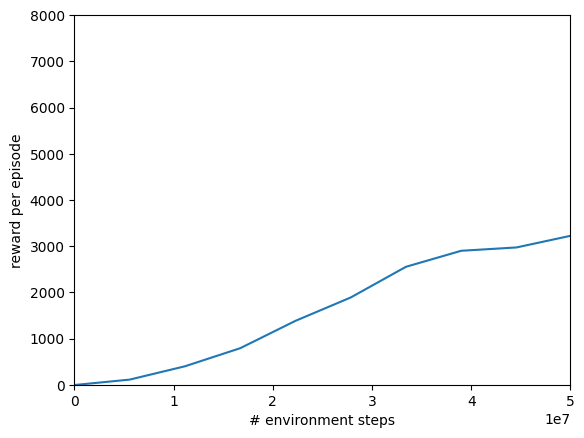

In [9]:
make_inference_fn, params, _ = train_fn(
  environment=env,
  progress_fn=progress
)

In [14]:
model_path = '/tmp/mjx_brax_ant_ppo_policy'
model.save_params(model_path, params)

# Training Policy with DSCRL

In [6]:
import einops
import corallab_stl.expression_jax as stl
# import importlib
# importlib.reload(stl)

In [7]:
test_env = {"state": jnp.ones((1, 64, 27)) * 0.9}

In [8]:
state = stl.Var("state", dim=27, y_velocity=14)

lb = jnp.array([0.4])
up = jnp.array([1.0])
neg_eye = -jnp.eye(state.y_velocity.dim)
pos_eye = jnp.eye(state.y_velocity.dim)
A = jnp.vstack((neg_eye, pos_eye))
b = jnp.concatenate((-lb, up))

def always_moderate_y_vel_exp_robustness(env):
    # get y value
    traj_y_vel = state.y_velocity.get_value(env)

    # compute at all time steps if y is in valid polytope
    prods_over_horizon = einops.einsum(A, traj_y_vel, "i j, b h j -> b h i")
    x = prods_over_horizon - b
    z = jnp.min(-x, axis=-1)

    # compute min of robustness trace over time
    return jnp.min(z, axis=1)

jit_rho_func = jax.jit(always_moderate_y_vel_exp_robustness)

In [9]:
jit_rho_func(test_env)

Array([0.10000002], dtype=float32)

In [13]:
train_fn = functools.partial(dscrl.train,
                             num_timesteps=50_000_000,
                             num_evals=10,
                             reward_scaling=10,
                             episode_length=1000,
                             normalize_observations=True,
                             action_repeat=1,
                             unroll_length=5,
                             num_minibatches=32,
                             num_updates_per_batch=4,
                             discounting=0.97,
                             learning_rate=3e-4,
                             entropy_cost=1e-2,
                             num_envs=4096,
                             batch_size=2048,
                             seed=1)

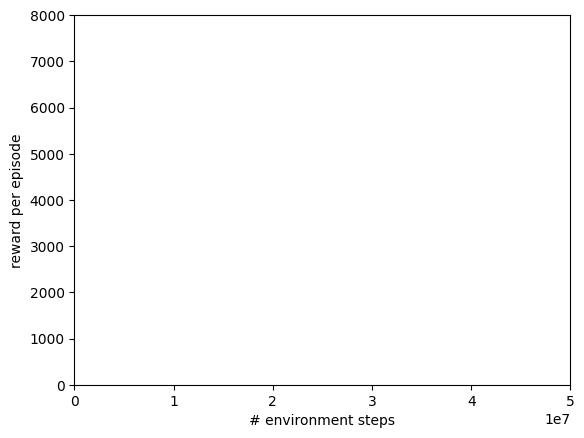

> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(132)compute_dscrl_loss()
    130   from IPython.core.debugger import Pdb; Pdb().set_trace()
    131 
--> 132   parametric_action_distribution = ppo_network.parametric_action_distribution
    133   policy_apply = ppo_network.policy_network.apply
    134   value_apply = ppo_network.value_network.apply



ipdb>  specification


<PjitFunction of <function always_moderate_y_vel_exp_robustness at 0x7703e1b37100>>


ipdb>  data


Transition(observation=Traced<ShapedArray(float32[2048,5,27])>with<DynamicJaxprTrace(level=3/1)>, action=Traced<ShapedArray(float32[2048,5,8])>with<DynamicJaxprTrace(level=3/1)>, reward=Traced<ShapedArray(float32[2048,5])>with<DynamicJaxprTrace(level=3/1)>, discount=Traced<ShapedArray(float32[2048,5], weak_type=True)>with<DynamicJaxprTrace(level=3/1)>, next_observation=Traced<ShapedArray(float32[2048,5,27])>with<DynamicJaxprTrace(level=3/1)>, extras={'policy_extras': {'log_prob': Traced<ShapedArray(float32[2048,5])>with<DynamicJaxprTrace(level=3/1)>, 'raw_action': Traced<ShapedArray(float32[2048,5,8])>with<DynamicJaxprTrace(level=3/1)>}, 'state_extras': {'truncation': Traced<ShapedArray(float32[2048,5], weak_type=True)>with<DynamicJaxprTrace(level=3/1)>}})


ipdb>  data.observation


Traced<ShapedArray(float32[2048,5,27])>with<DynamicJaxprTrace(level=3/1)>


ipdb>  n


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(133)compute_dscrl_loss()
    131 
    132   parametric_action_distribution = ppo_network.parametric_action_distribution
--> 133   policy_apply = ppo_network.policy_network.apply
    134   value_apply = ppo_network.value_network.apply
    135 



ipdb>  n


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(134)compute_dscrl_loss()
    132   parametric_action_distribution = ppo_network.parametric_action_distribution
    133   policy_apply = ppo_network.policy_network.apply
--> 134   value_apply = ppo_network.value_network.apply
    135 
    136   # Put the time dimension first.



ipdb>  n


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(137)compute_dscrl_loss()
    135 
    136   # Put the time dimension first.
--> 137   data = jax.tree_util.tree_map(lambda x: jnp.swapaxes(x, 0, 1), data)
    138   policy_logits = policy_apply(normalizer_params, params.policy,
    139                                data.observation)



ipdb>  n


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(138)compute_dscrl_loss()
    136   # Put the time dimension first.
    137   data = jax.tree_util.tree_map(lambda x: jnp.swapaxes(x, 0, 1), data)
--> 138   policy_logits = policy_apply(normalizer_params, params.policy,
    139                                data.observation)
    140 



ipdb>  


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(139)compute_dscrl_loss()
    137   data = jax.tree_util.tree_map(lambda x: jnp.swapaxes(x, 0, 1), data)
    138   policy_logits = policy_apply(normalizer_params, params.policy,
--> 139                                data.observation)
    140 
    141   baseline = value_apply(normalizer_params, params.value, data.observation)



ipdb>  n


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(138)compute_dscrl_loss()
    136   # Put the time dimension first.
    137   data = jax.tree_util.tree_map(lambda x: jnp.swapaxes(x, 0, 1), data)
--> 138   policy_logits = policy_apply(normalizer_params, params.policy,
    139                                data.observation)
    140 



ipdb>  n


> /home/tassos/phd/research/second-project/task-aware-skill-composition/task_aware_skill_composition/brax/agents/dscrl/losses.py(141)compute_dscrl_loss()
    139                                data.observation)
    140 
--> 141   baseline = value_apply(normalizer_params, params.value, data.observation)
    142 
    143   bootstrap_value = value_apply(normalizer_params, params.value,



ipdb>  data.observation.shape


(5, 2048, 27)


ipdb>  data.next_observation.shape


(5, 2048, 27)


ipdb>  data.next_observation[0]


Traced<ShapedArray(float32[2048,27])>with<DynamicJaxprTrace(level=3/1)>


In [ ]:
make_inference_fn, params, _ = train_fn(
    environment=env,
    specification = jit_rho_func,
  progress_fn=progress
)

# Visualizing Policy

In [15]:
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [18]:
# reset the environment
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

# grab a trajectory acting according to the policy function
rollout = [state.pipeline_state]
n_steps = 100
render_every = 1

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)

    if state.done:
        break

    rollout.append(state.pipeline_state)

In [19]:
mediapy.show_video(env.render(rollout, camera='track'), fps=1.0 / env.dt)